In [12]:
import pandas as pd
import sklearn as skr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

# 设置字体为SimHei显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False # 设置正常显示符号

In [13]:
import warnings
warnings.filterwarnings('ignore')

# 基于周期因子的时间序列计算

支付数据、客流量数据、交通数据等时间序列通常都具有明显的周期性

* 周期性是核心
* 确定周期（一周、一月）
* 确定组成一个周期的元素（周1-周日、1号-31号）
* 结合STL分解观察周期变化
* 缺点：不考虑节假日、突发事件等

## Example

In [23]:
flow_data = [[20, 10, 70, 50, 250, 200, 100], 
             [26, 18, 66, 50, 180, 140, 80], 
             [15, 8, 67, 60, 270, 160, 120]
            ]
flow_data = pd.DataFrame(flow_data, columns = ['MON','TUES','WED','THUR','FRI','SAT','SUN'])
flow_data

,MON,TUES,WED,THUR,FRI,SAT,SUN
0,20,10,70,50,250,200,100
1,26,18,66,50,180,140,80
2,15,8,67,60,270,160,120


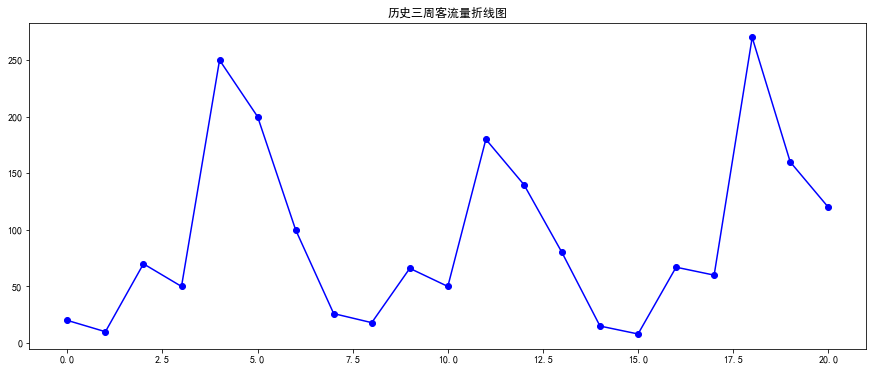

In [24]:
plt.figure(figsize = (15, 6))
plt.plot(np.array(flow_data).reshape(-1), color = 'blue', marker = 'o')
plt.title('历史三周客流量折线图')
plt.show()

可以看出这是个以周为单位的周期性时间序列数据

任务：给定前三周的客流量数据，预测第四周额度客流量数据

## Step 1：获取周期因子

计算方法：

* 方法一：对于每个流量数值，除以其对应所在周期的流量均值，然后按周期中的元素（在本例中即翌日），取中位数

* 方法二：季节指数的计算方式；获得周期中每个元素单位的均值，再除以整体均值

In [89]:
np.mean(np.mean(flow_data))

93.33333333333334

In [91]:
per_fac_1 = []
for weekday in ['MON','TUES','WED','THUR','FRI','SAT','SUN']:
    per_fac_1.append(np.median(flow_data[weekday] / np.mean(flow_data, axis = 1)))

print('依据方法一计算的周期因子:\n',per_fac_1)
    

依据方法一计算的周期因子:
 [0.2, 0.1, 0.7, 0.6, 2.5, 1.75, 1.0]


In [92]:
per_fac_2 = []
for weekday in ['MON','TUES','WED','THUR','FRI','SAT','SUN']:
    per_fac_2.append(np.mean(flow_data[weekday] / np.mean(np.mean(flow_data))))

print('依据方法二计算的周期因子:\n',per_fac_2)

依据方法二计算的周期因子:
 [0.21785714285714283, 0.12857142857142856, 0.725, 0.5714285714285714, 2.4999999999999996, 1.7857142857142856, 1.0714285714285714]


## Step 2：预测

* 对于最后一个周期的数据，去周期（所有元素除以周期因子）后取均值，为Base值；
* Base值乘以Step 1中计算的周期因子，得到下一个周期的预测。

In [38]:
# 计算Base
Base = np.mean(flow_data.iloc[-1,:].values / per_fac)
print('Base值为:{:.2f}'.format(Base))

# 预测，Base乘周期因子
Pred = [Base * i for i in per_fac]
print('下一周的客流量预测为：\n',Pred)

Base值为:95.73
下一周的客流量预测为：
 [19.146938775510204, 9.573469387755102, 67.0142857142857, 57.4408163265306, 239.33673469387753, 167.53571428571428, 95.73469387755101]


# 应用于余额宝数据的预测

In [39]:
# 读取数据
datapath = 'Dataset/'

data_balance = pd.read_csv(datapath + "user_balance_table.csv")
bank = pd.read_csv(datapath + "mfd_bank_shibor.csv")
share = pd.read_csv(datapath + "mfd_day_share_interest.csv")
users = pd.read_csv(datapath + "user_profile_table.csv")


In [42]:
# 以日期为单位聚合申购与赎回数据
data_balance['Date'] = pd.to_datetime(data_balance['report_date'], format = '%Y%m%d')
data_balance['Day'] = data_balance['Date'].dt.day # 日信息
data_balance['Month'] = data_balance['Date'].dt.month # 月信息
data_balance['Year'] = data_balance['Date'].dt.year # 年信息
data_balance['Week'] = data_balance['Date'].dt.week # 周信息
data_balance['Weekday'] = data_balance['Date'].dt.weekday # 工作日信息

balanceGroup = data_balance.groupby(by = 'Date')

total_balance = balanceGroup.sum()[['total_purchase_amt', 'total_redeem_amt']]
# 在分组数据对象方法的输出结果中，分组的依据（在此为日期）是索引，需要将索引重置
total_balance.reset_index(inplace = True)

# 同样对聚合数据增加时间戳
total_balance['Day'] = total_balance['Date'].dt.day # 日信息
total_balance['Month'] = total_balance['Date'].dt.month # 月信息
total_balance['Year'] = total_balance['Date'].dt.year # 年信息
total_balance['Week'] = total_balance['Date'].dt.week # 周信息
total_balance['Weekday'] = total_balance['Date'].dt.weekday # 工作日信息

In [43]:
total_balance.head()

,Date,total_purchase_amt,total_redeem_amt,Day,Month,Year,Week,Weekday
0,2013-07-01,32488348,5525022,1,7,2013,27,0
1,2013-07-02,29037390,2554548,2,7,2013,27,1
2,2013-07-03,27270770,5953867,3,7,2013,27,2
3,2013-07-04,18321185,6410729,4,7,2013,27,3
4,2013-07-05,11648749,2763587,5,7,2013,27,4


## 基于周期因子（以星期为周期）的预测

选取时段：

* 训练集时段：20140331（周一）到20140803（周日）
* 测试集时段：20140804到20140831

In [236]:
df_tmp_train = total_balance[(total_balance['Date'] >= pd.to_datetime('20140331')) & (total_balance['Date'] <= pd.to_datetime('20140803'))]
df_tmp_test = total_balance[(total_balance['Date'] >= pd.to_datetime('20140804')) & (total_balance['Date'] <= pd.to_datetime('20140831'))]

df_tmp_train.reset_index(inplace = True, drop = True)
df_tmp_test.reset_index(inplace = True, drop = True)

report_date = df_tmp_test['Date']

In [237]:
# 以翌日为单位重新组织数据，每行为每个周期（星期），没列为一个周期元素（翌日）
df_purchase = pd.DataFrame()
df_redeem = pd.DataFrame()
WD_columns = ['MON','TUES','WED','THUR','FRI','SAT','SUN']
for weekday in range(7):
    purchase = df_tmp_train[df_tmp_train['Weekday'] == weekday]['total_purchase_amt'].reset_index(drop = True)
    df_purchase[WD_columns[weekday]] = purchase
    
    redeem = df_tmp_train[df_tmp_train['Weekday'] == weekday]['total_redeem_amt'].reset_index(drop = True)
    df_redeem[WD_columns[weekday]] = redeem

In [238]:
df_purchase

,MON,TUES,WED,THUR,FRI,SAT,SUN
0,398884905,453320585,355347118,363877120,251895894,202336542,129477254
1,196936223,354770149,383347565,386567460,237829882,177642053,208172985
2,309853269,428681231,387847838,355792647,239300383,268729366,191259529
3,301134667,285248757,313677307,318358891,220927432,151625415,146837951
4,324937272,330607104,260091330,193045106,125336258,185094488,303087562
5,370924149,318002728,417327518,392838756,281479009,287240171,182424063
6,325108597,275241493,305474522,313367089,231967423,170983868,164419642
7,259077930,453955303,297799722,344636549,249546195,160073254,166943526
8,344890868,299049555,276134813,320549863,226547701,146823669,183489775
9,158219402,270887462,274460744,380042567,301413900,187801995,302171269


周期因子第一种算法

In [239]:
# 获取周期因子1
per_fac_pur = []
per_fac_red = []

for weekday in ['MON','TUES','WED','THUR','FRI','SAT','SUN']:
    per_fac_pur.append(np.median(df_purchase[weekday] / np.mean(df_purchase, axis = 1)))
    per_fac_red.append(np.median(df_redeem[weekday] / np.mean(df_redeem, axis = 1)))

print('周期因子1（申购）:\n',per_fac_pur)
print('周期因子1（赎回）:\n',per_fac_red)

周期因子1（申购）:
 [1.1965358189008, 1.1567976169441638, 1.188143391219503, 1.2212892678741607, 0.8789357021729176, 0.6615813281270675, 0.6629825461706491]
周期因子1（赎回）:
 [1.2448323912356174, 1.1625904253849315, 1.0751002783705905, 1.0755597915837694, 0.964592130994026, 0.6513170928282659, 0.6495216887392931]


In [240]:
# 预测

# 申购份额预测未来4周
base_pur = []
# 第一个Base为最后周去周期后的均值
base_pur.append(np.mean(df_purchase.iloc[-1,:].values / per_fac_pur))
pred_pur_res = []
for i in range(4):
    base_val = base_pur[i]
    pred_val = [base_val * fac for fac in per_fac_pur]
    base_next = np.mean(np.array(pred_val) / np.array(per_fac_pur))# 下一周的预测base
    
    pred_pur_res.append(pred_val)
    base_pur.append(base_next)

# 赎回份额预测未来4周
base_red = []
# 第一个Base为最后周去周期后的均值
base_red.append(np.mean(df_redeem.iloc[-1,:].values / per_fac_red))
pred_red_res = []
for i in range(4):
    base_val = base_red[i]
    pred_val = [base_val * fac for fac in per_fac_red]
    base_next = np.mean(np.array(pred_val) / np.array(per_fac_red))# 下一周的预测base
    
    pred_red_res.append(pred_val)
    base_red.append(base_next)

In [241]:
# 作比较
df_tmp_com = df_tmp_test.iloc[:, :3]
df_tmp_com['pred_purchase_week_fac1'] = np.array(pred_pur_res).reshape(-1) # 基于周为周期的周期因子1对申购金额预测结果
df_tmp_com['pred_redeem_week_fac1'] = np.array(pred_red_res).reshape(-1) # 基于周为周期的周期因子1对赎回金额预测结果
df_tmp_com

,Date,total_purchase_amt,total_redeem_amt,pred_purchase_week_fac1,pred_redeem_week_fac1
0,2014-08-04,330640884,322907524,3.104272e+08,3.114464e+08
1,2014-08-05,394780870,221706539,3.001176e+08,2.908702e+08
2,2014-08-06,288821016,282346594,3.082499e+08,2.689809e+08
3,2014-08-07,247646474,253659514,3.168492e+08,2.690959e+08
4,2014-08-08,233903717,311648757,2.280295e+08,2.413327e+08
5,2014-08-09,160262764,163611708,1.716395e+08,1.629540e+08
6,2014-08-10,259534870,189909225,1.720030e+08,1.625048e+08
7,2014-08-11,331550471,418603336,3.104272e+08,3.114464e+08
8,2014-08-12,258493673,309754858,3.001176e+08,2.908702e+08
9,2014-08-13,261506619,303975517,3.082499e+08,2.689809e+08


周期因子第二种算法

In [242]:
# 获取周期因子1
per_fac_pur = []
per_fac_red = []

for weekday in ['MON','TUES','WED','THUR','FRI','SAT','SUN']:
    per_fac_pur.append(np.mean(df_purchase[weekday] / np.mean(np.mean(df_purchase) ) ) )
    per_fac_red.append(np.median(df_redeem[weekday] / np.mean(np.mean(df_redeem) ) ) )

print('周期因子2（申购）:\n',per_fac_pur)
print('周期因子2（赎回）:\n',per_fac_red)

# 预测

# 申购份额预测未来4周
base_pur = []
# 第一个Base为最后周去周期后的均值
base_pur.append(np.mean(df_purchase.iloc[-1,:].values / per_fac_pur))
pred_pur_res = []
for i in range(4):
    base_val = base_pur[i]
    pred_val = [base_val * fac for fac in per_fac_pur]
    base_next = np.mean(np.array(pred_val) / np.array(per_fac_pur))# 下一周的预测base
    
    pred_pur_res.append(pred_val)
    base_pur.append(base_next)

# 赎回份额预测未来4周
base_red = []
# 第一个Base为最后周去周期后的均值
base_red.append(np.mean(df_redeem.iloc[-1,:].values / per_fac_red))
pred_red_res = []
for i in range(4):
    base_val = base_red[i]
    pred_val = [base_val * fac for fac in per_fac_red]
    base_next = np.mean(np.array(pred_val) / np.array(per_fac_red))# 下一周的预测base
    
    pred_red_res.append(pred_val)
    base_red.append(base_next)

周期因子2（申购）:
 [1.1619256609723152, 1.1968156102269254, 1.1921718727850372, 1.173146603853696, 0.891195123139458, 0.691863112490194, 0.692882016532375]
周期因子2（赎回）:
 [1.1629045691848794, 1.1334399924169216, 1.039301983102246, 1.0427218769659168, 0.9560340870534635, 0.581666653053419, 0.6380567116833378]


In [243]:
df_tmp_com['pred_purchase_week_fac2'] = np.array(pred_pur_res).reshape(-1) # 基于周为周期的周期因子2对申购金额预测结果
df_tmp_com['pred_redeem_week_fac2'] = np.array(pred_red_res).reshape(-1) # 基于周为周期的周期因子2对赎回金额预测结果
df_tmp_com

,Date,total_purchase_amt,total_redeem_amt,pred_purchase_week_fac1,pred_redeem_week_fac1,pred_purchase_week_fac2,pred_redeem_week_fac2
0,2014-08-04,330640884,322907524,3.104272e+08,3.114464e+08,2.979317e+08,3.042312e+08
1,2014-08-05,394780870,221706539,3.001176e+08,2.908702e+08,3.068779e+08,2.965229e+08
2,2014-08-06,288821016,282346594,3.082499e+08,2.689809e+08,3.056871e+08,2.718951e+08
3,2014-08-07,247646474,253659514,3.168492e+08,2.690959e+08,3.008088e+08,2.727898e+08
4,2014-08-08,233903717,311648757,2.280295e+08,2.413327e+08,2.285131e+08,2.501112e+08
5,2014-08-09,160262764,163611708,1.716395e+08,1.629540e+08,1.774020e+08,1.521717e+08
6,2014-08-10,259534870,189909225,1.720030e+08,1.625048e+08,1.776632e+08,1.669241e+08
7,2014-08-11,331550471,418603336,3.104272e+08,3.114464e+08,2.979317e+08,3.042312e+08
8,2014-08-12,258493673,309754858,3.001176e+08,2.908702e+08,3.068779e+08,2.965229e+08
9,2014-08-13,261506619,303975517,3.082499e+08,2.689809e+08,3.056871e+08,2.718951e+08


## 基于周期因子（以月为周期）的预测

选取时段：

* 训练集时段：201404到201407
* 测试集时段：201408

In [244]:
df_tmp_train = total_balance[(total_balance['Date'] >= pd.to_datetime('20140301')) & (total_balance['Date'] <= pd.to_datetime('20140731'))]
df_tmp_test = total_balance[(total_balance['Date'] >= pd.to_datetime('20140801')) & (total_balance['Date'] <= pd.to_datetime('20140831'))]

df_tmp_train.reset_index(inplace = True, drop = True)
df_tmp_test.reset_index(inplace = True, drop = True)

In [245]:
# 以日为单位重新组织数据，每行为每个周期（月），没列为一个周期元素（日）
df_purchase = pd.DataFrame()
df_redeem = pd.DataFrame()
# 先获取都有的日份，即1-30日
for day in range(1, 31):
    purchase = df_tmp_train[df_tmp_train['Day'] == day]['total_purchase_amt'].reset_index(drop = True)
    df_purchase['day{:02d}'.format(day)] = purchase
    
    redeem = df_tmp_train[df_tmp_train['Day'] == day]['total_redeem_amt'].reset_index(drop = True)
    df_redeem['day{:02d}'.format(day)] = redeem

# 31日数据，3月，5月和7月有
pur_31 = df_tmp_train[df_tmp_train['Day'] == 31]['total_purchase_amt'].reset_index(drop = True).values
df_purchase['day31'] = [pur_31[0], None, pur_31[1], None, pur_31[1]]
#df_purchase['day31'] = [None, pur_31[0], None, pur_31[1]]

red_31 = df_tmp_train[df_tmp_train['Day'] == 31]['total_redeem_amt'].reset_index(drop = True).values
#df_redeem['day31'] = [None, red_31[0], None, red_31[1]]
df_redeem['day31'] = [red_31[0], None, red_31[1], None, red_31[2]]

In [246]:
df_tmp_train[df_tmp_train['Day'] == 31]

,Date,total_purchase_amt,total_redeem_amt,Day,Month,Year,Week,Weekday
30,2014-03-31,398884905,423852634,31,3,2014,14,0
91,2014-05-31,146823669,142862063,31,5,2014,22,5
152,2014-07-31,191728916,277194379,31,7,2014,31,3


In [247]:
df_purchase

,day01,day02,day03,day04,day05,day06,day07,day08,day09,day10,...,day22,day23,day24,day25,day26,day27,day28,day29,day30,day31
0,362865580,276202230,505305862,524146340,454295491,561787770,380139779,243274169,244752519,497338076,...,191700135,167456369,313180334,314345006,272935544,266231082,225966355,160250985,205533934,398884905.0
1,453320585,355347118,363877120,251895894,202336542,129477254,196936223,354770149,383347565,386567460,...,285248757,313677307,318358891,220927432,151625415,146837951,324937272,330607104,260091330,NaN
2,193045106,125336258,185094488,303087562,370924149,318002728,417327518,392838756,281479009,287240171,...,344636549,249546195,160073254,166943526,344890868,299049555,276134813,320549863,226547701,146823669.0
3,183489775,158219402,270887462,274460744,380042567,301413900,187801995,302171269,366114374,354031597,...,147180819,232227670,245450766,264663201,297628039,264282703,153826161,158801540,334054112,NaN
4,384428753,384555819,297894643,211649838,169383796,199569025,272182847,224240103,278005555,283095921,...,243084133,265461894,277044480,181641088,128268053,151406251,371762756,228093046,209917272,146823669.0


In [248]:
def get_day_fac1(day, cate):
    if cate == 'purchase':
        sub_info = df_purchase['day{:02d}'.format(day)]
        div = np.mean(df_purchase, axis = 1)
    elif cate == 'redeem':
        sub_info = df_redeem['day{:02d}'.format(day)]
        div = np.mean(df_redeem, axis = 1)
    fac_list = sub_info / div
    return  np.median(fac_list.dropna())

def get_day_fac2(day, cate):
    if cate == 'purchase':
        sub_info = df_purchase['day{:02d}'.format(day)]
        div = np.mean(df_purchase.dropna().values)
    elif cate == 'redeem':
        sub_info = df_redeem['day{:02d}'.format(day)]
        div = np.mean(df_redeem.dropna().values)
    
    return np.mean(sub_info.dropna() ) / div

In [256]:
pred_pur_val

[269203378.8279647,
 204909414.54358566,
 298295104.4070896,
 259991815.46850884,
 337033568.08741474,
 285524064.1206,
 272548743.8983047,
 286241506.39820874,
 278379279.3966956,
 335367879.1938474,
 208951538.60127988,
 279695306.7778578,
 205488056.17379385,
 255140049.7129716,
 287475990.36411685,
 338394458.0283792,
 253351404.45533755,
 209240500.53289533,
 237672324.6397944,
 238319687.4044056,
 262737838.01012564,
 243410912.33702332,
 228928123.1738475,
 232511175.66188678,
 192757600.5083767,
 202485919.57123253,
 197512001.0650361,
 253319929.33433166,
 228399672.73631403,
 210199464.94335392,
 147021044.86580837]

In [257]:
# 获取周期因子1
per_fac_pur = []
per_fac_red = []

for day in range(1, 32):
    per_fac_pur.append(get_day_fac1(day, 'purchase'))
    per_fac_red.append(get_day_fac1(day, 'redeem'))

print('周期因子1（申购）:\n',per_fac_pur)
print('周期因子1（赎回）:\n',per_fac_red)

# 申购份额预测未来一个月
base_val = np.mean(df_purchase.iloc[-1,:].values / per_fac_pur)
pred_pur_val = [base_val * fac for fac in per_fac_pur]

# 赎回份额预测未来一个月
base_val = np.mean(df_redeem.iloc[-1,:].values / per_fac_red)
pred_red_val = [base_val * fac for fac in per_fac_red]

df_tmp_com['pred_purchase_month_fac1'] = np.array(pred_pur_val).reshape(-1)[3:] # 基于月为周期的周期因子1对申购金额预测结果
df_tmp_com['pred_redeem_month_fac1'] = np.array(pred_red_val).reshape(-1)[3:] # 基于月为周期的周期因子1对赎回金额预测结果

周期因子1（申购）:
 [1.0843351815707152, 0.8253629214908905, 1.2015149200843422, 1.047231552814596, 1.3575511453035645, 1.1500739301971117, 1.0978101128912674, 1.1529637449748622, 1.121295162729154, 1.350841849615263, 0.8416443565275296, 1.126596042664307, 0.8276936555250912, 1.0276889292250493, 1.1579361728884603, 1.3630327289584876, 1.0204843726230994, 0.8428082779833055, 0.9573299726572896, 0.9599375113292146, 1.0582923681142589, 0.9804446622266606, 0.9221088497815335, 0.9365411718686881, 0.7764161380751353, 0.815601228036955, 0.7955665804407185, 1.020357592709714, 0.9199802828830468, 0.846670929531966, 0.592192015097851]
周期因子1（赎回）:
 [0.6681429489945514, 0.7785742830607972, 1.107707275669619, 0.9592029428406609, 0.9900783537022149, 0.7689305235504111, 0.9205262399937387, 1.0387768605808878, 0.9795712276484592, 0.9741392197707788, 0.8720675474324534, 0.7461726371205715, 1.0023884346236753, 1.0344649858823982, 0.9507965430935055, 1.1316295113605856, 1.1024560986242662, 0.9388017937607905, 0.8

In [258]:
# 获取周期因子2
per_fac_pur = []
per_fac_red = []

for day in range(1, 32):
    per_fac_pur.append(get_day_fac2(day, 'purchase'))
    per_fac_red.append(get_day_fac2(day, 'redeem'))

print('周期因子2（申购）:\n',per_fac_pur)
print('周期因子2（赎回）:\n',per_fac_red)

# 申购份额预测未来一个月
base_val = np.mean(df_purchase.iloc[-1,:].values / per_fac_pur)
pred_pur_val = [base_val * fac for fac in per_fac_pur]

# 赎回份额预测未来一个月
base_val = np.mean(df_redeem.iloc[-1,:].values / per_fac_red)
pred_red_val = [base_val * fac for fac in per_fac_red]

df_tmp_com['pred_purchase_month_fac2'] = np.array(pred_pur_val).reshape(-1)[3:] # 基于月为周期的周期因子2对申购金额预测结果
df_tmp_com['pred_redeem_month_fac2'] = np.array(pred_red_val).reshape(-1)[3:] # 基于月为周期的周期因子2对赎回金额预测结果

周期因子2（申购）:
 [1.1091048825960492, 0.9139652871645322, 1.141390184063783, 1.1007297764467368, 1.1089872639474265, 1.0620591657601248, 1.022774903504946, 1.0670125814691034, 1.0926135060078122, 1.2716386637381198, 0.9754464832069851, 0.9773317402290791, 0.8624352867409938, 0.961740487300824, 1.0761904942833505, 1.1753856971381238, 0.9768946769707285, 0.9728685768590626, 1.0096667033572042, 1.0114316026354289, 1.0108098216853338, 0.8522140310986661, 0.8638307780618436, 0.9241248326435517, 0.8076781426662374, 0.8406089353113672, 0.7931122663515927, 0.9512131358307894, 0.8426867229515703, 0.8692983595716228, 0.8116866816260422]
周期因子2（赎回）:
 [0.825007786937734, 0.8131108478893948, 1.1802252755225056, 1.0222464513295022, 0.9347068806908366, 0.8522423409268799, 0.8358393367886423, 0.8374530791525552, 0.9281171699089616, 0.9751123525752654, 1.0078240069552946, 0.8701265783514613, 0.9563313399400836, 1.112168985229309, 0.816930006251194, 1.181578553432899, 1.1793952772311291, 1.0135216518005046, 0

In [261]:
df_tmp_com

,Date,total_purchase_amt,total_redeem_amt,pred_purchase_week_fac1,pred_redeem_week_fac1,pred_purchase_week_fac2,pred_redeem_week_fac2,pred_purchase_month_fac1,pred_redeem_month_fac1,pred_purchase_month_fac2,pred_redeem_month_fac2
0,2014-08-04,330640884,322907524,3.104272e+08,3.114464e+08,2.979317e+08,3.042312e+08,2.599918e+08,2.675898e+08,2.771686e+08,2.853674e+08
1,2014-08-05,394780870,221706539,3.001176e+08,2.908702e+08,3.068779e+08,2.965229e+08,3.370336e+08,2.762031e+08,2.792478e+08,2.609301e+08
2,2014-08-06,288821016,282346594,3.082499e+08,2.689809e+08,3.056871e+08,2.718951e+08,2.855241e+08,2.145093e+08,2.674311e+08,2.379095e+08
3,2014-08-07,247646474,253659514,3.168492e+08,2.690959e+08,3.008088e+08,2.727898e+08,2.725487e+08,2.568001e+08,2.575392e+08,2.333305e+08
4,2014-08-08,233903717,311648757,2.280295e+08,2.413327e+08,2.285131e+08,2.501112e+08,2.862415e+08,2.897886e+08,2.686784e+08,2.337810e+08
5,2014-08-09,160262764,163611708,1.716395e+08,1.629540e+08,1.774020e+08,1.521717e+08,2.783793e+08,2.732720e+08,2.751248e+08,2.590905e+08
6,2014-08-10,259534870,189909225,1.720030e+08,1.625048e+08,1.776632e+08,1.669241e+08,3.353679e+08,2.717566e+08,3.202042e+08,2.722095e+08
7,2014-08-11,331550471,418603336,3.104272e+08,3.114464e+08,2.979317e+08,3.042312e+08,2.089515e+08,2.432816e+08,2.456217e+08,2.813412e+08
8,2014-08-12,258493673,309754858,3.001176e+08,2.908702e+08,3.068779e+08,2.965229e+08,2.796953e+08,2.081605e+08,2.460964e+08,2.429020e+08
9,2014-08-13,261506619,303975517,3.082499e+08,2.689809e+08,3.056871e+08,2.718951e+08,2.054881e+08,2.796373e+08,2.171650e+08,2.669667e+08
